Образовательный центр МГТУ им. Н.Э. Баумана

# Выпускная квалификационная работа по курсу "Data Science"

## Тема: Прогнозирование конечных свойств новых материалов (композиционных материалов).

Выполнил: Четвериков А.В.

## 6. Разработка и обучение модели, рекомендующей соотношение матрица-наполнитель

In [43]:
# Загрузим необходимые библиотеки и модули 

import pathlib               #для задания относительного пути к файлам
from pathlib import Path

import joblib     # для сохранения/загрузки моделей машинного обучения

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns



from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import Normalizer, LabelEncoder, MinMaxScaler, StandardScaler


from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Concatenate
from keras.models import load_model
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression, LogisticRegressionCV, Lasso

In [44]:
# Определим путь к предварительно подготовленному датасету

dir_path = pathlib.Path.cwd()

paht_out = Path(dir_path.parents[0], 'datasets', 'out_no_blowout.xlsx')

# так же можно задать путь явно:   
# paht_bp = r"C:\ ... \vkr\datasets\out_no_blowout.xlsx"

In [45]:
#Загрузим  датасет
df = pd.read_excel(paht_out)
df.head()

,Unnamed: 0,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,1,1.857143,2030.0,738.736842,50.00,23.750000,284.615385,210.0,70.0,3000.0,220.0,0,4.0,60.0
1,3,1.857143,2030.0,738.736842,129.00,21.250000,300.000000,210.0,70.0,3000.0,220.0,0,5.0,47.0
2,4,2.771331,2030.0,753.000000,111.86,22.267857,284.615385,210.0,70.0,3000.0,220.0,0,5.0,57.0
3,5,2.767918,2000.0,748.000000,111.86,22.267857,284.615385,210.0,70.0,3000.0,220.0,0,5.0,60.0
4,6,2.569620,1910.0,807.000000,111.86,22.267857,284.615385,210.0,70.0,3000.0,220.0,0,5.0,70.0


In [46]:
#Удалим первый столбец, так как он не несет никакой информации
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,1.857143,2030.0,738.736842,50.00,23.750000,284.615385,210.0,70.0,3000.0,220.0,0,4.0,60.0
1,1.857143,2030.0,738.736842,129.00,21.250000,300.000000,210.0,70.0,3000.0,220.0,0,5.0,47.0
2,2.771331,2030.0,753.000000,111.86,22.267857,284.615385,210.0,70.0,3000.0,220.0,0,5.0,57.0
3,2.767918,2000.0,748.000000,111.86,22.267857,284.615385,210.0,70.0,3000.0,220.0,0,5.0,60.0
4,2.569620,1910.0,807.000000,111.86,22.267857,284.615385,210.0,70.0,3000.0,220.0,0,5.0,70.0


In [47]:
# разделим датасет на целевую переменную и признаки

In [48]:
target_val = 'Соотношение матрица-наполнитель'

In [49]:
df_target_val = df.loc[:, df.columns == target_val]
df_target_val.describe()

,Соотношение матрица-наполнитель
count,996.000000
mean,2.935559
std,0.908608
min,0.389403
25%,2.319283
50%,2.908811
75%,3.552539
max,5.591742


In [50]:
df_signs = df.loc[:, df.columns != target_val]
df_signs.describe()

,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
count,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000
mean,1975.560961,739.322328,110.913646,22.231151,285.939388,479.197374,73.303787,2465.208339,218.351938,44.819277,6.899334,57.297080
std,73.041367,327.708109,27.857831,2.387763,40.298154,277.918586,3.102701,484.183286,58.719705,45.022244,2.553903,11.749357
min,1784.482245,2.436909,29.956150,15.695894,173.484920,0.603740,64.054061,1036.856605,53.548916,0.000000,0.037639,23.143401
25%,1923.713503,501.502849,92.597812,20.581352,258.951066,266.205564,71.233343,2134.535871,179.908444,0.000000,5.082481,50.022145
50%,1977.574305,741.367350,110.858657,22.207416,285.853960,450.345833,73.207875,2456.394188,218.697660,0.000000,6.913444,57.516472
75%,2021.238927,961.650808,130.001450,23.980937,313.053889,690.593845,75.314494,2760.163022,257.262334,90.000000,8.586121,64.930896
max,2192.738783,1649.415706,192.851702,28.955094,403.652861,1291.340115,82.525773,3848.436732,386.903431,90.000000,14.440522,92.042139


In [51]:
# нормализуем наши датасеты

In [52]:
# отдельно целевая, отдельно признаки

In [53]:
# 1 - Normalizer()
# 2 - MinMaxScaler()
# 3 - StandardScaler()
# 4 - normalize()


preobraz = (2, )

df_target_val_norm = df_target_val
df_signs_norm = df_signs

for n in preobraz:
    if n == 1:
        norm_1 = Normalizer(norm = 'l2', copy = True)
        col = df_target_val.columns
        result = norm_1.fit_transform(df_target_val_norm.T)
        df_target_val_norm = pd.DataFrame(result.T, columns = col)
        
        norm_2 = Normalizer(norm = 'l2', copy = True)
        col = df_signs.columns
        result = norm_2.fit_transform(df_signs_norm.T)
        df_signs_norm = pd.DataFrame(result.T, columns = col)
        
        # сохраним нормализаторы
        joblib_file = "norm_y.joblib" 
        joblib.dump(norm_1, joblib_file)
        
        joblib_file = "norm_x.joblib" 
        joblib.dump(norm_2, joblib_file)        
        
    if n == 2:
        scaler_1 = MinMaxScaler((0.1, 0.9))
        col = df_target_val.columns
        result = scaler_1.fit_transform(df_target_val_norm)
        df_target_val_norm = pd.DataFrame(result, columns = col)
        
        scaler_2 = MinMaxScaler((0.1, 0.9))
        col = df_signs.columns
        result = scaler_2.fit_transform(df_signs_norm)
        df_signs_norm = pd.DataFrame(result, columns = col)
        
        # сохраним нормализаторы
        joblib_file = "norm_minmax_y.joblib" 
        joblib.dump(scaler_1, joblib_file)
        
        joblib_file = "norm_minmax_x.joblib" 
        joblib.dump(scaler_2, joblib_file)        
        
        
        
    if n == 3:
        scaler_1 = StandardScaler(copy = True, 
                           with_mean = True, 
                           with_std = True).fit(df_target_val_norm)
        df_standart_X1 = scaler_1.transform(df_target_val_norm)
        df_target_val_std = pd.DataFrame(df_standart_X1)
        df_target_val_std.columns = df_target_val.columns
        df_target_val_norm = df_target_val_std
        
        scaler_2 = StandardScaler(copy = True, 
                           with_mean = True, 
                           with_std = True).fit(df_signs_norm)
        df_standart_X2 = scaler_2.transform(df_signs_norm)
        df_signs_std = pd.DataFrame(df_standart_X2)
        df_signs_std.columns = df_signs.columns
        df_signs_norm = df_signs_std
        
        # сохраним стандартизаторы
        joblib_file = "stand_y.joblib" 
        joblib.dump(scaler_1, joblib_file)
        
        joblib_file = "stand_x.joblib" 
        joblib.dump(scaler_2, joblib_file) 
        
        
    if n == 4:
        res_1, k_norm_1 = preprocessing.normalize(df_target_val_norm, norm='l2', return_norm = True, axis=0)
        df_target_val_norm = pd.DataFrame(res_1, columns = df_target_val.columns)
        
        res_2, k_norm_2 = preprocessing.normalize(df_signs_norm, norm='l2', return_norm = True, axis=0)
        df_signs_norm = pd.DataFrame(res_2, columns = df_signs.columns)
        


Text(0.5, 1, '4')

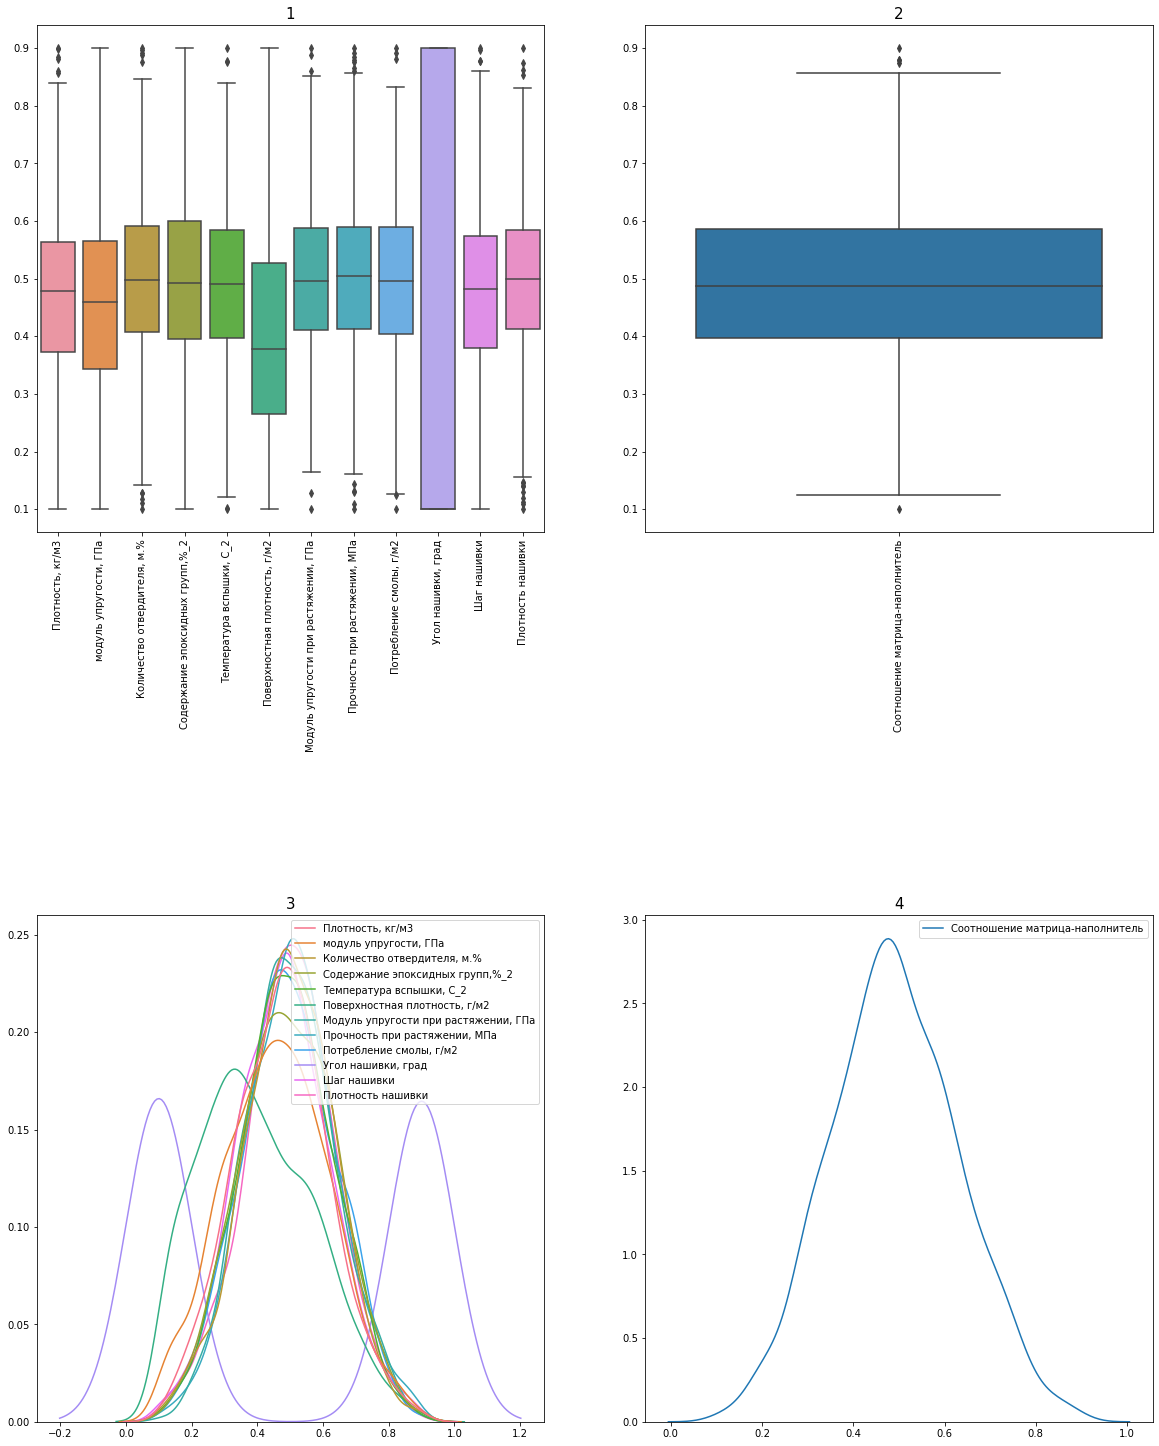

In [54]:


plt.figure(figsize = (20,30))


plt.subplot(2, 2, 1, box_aspect= 1)
ax = sns.boxplot(data = df_signs_norm)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.ylabel(None)
plt.xlabel(None)
plt.title('1', y = 1, size = 15)

plt.subplot(2, 2, 2, box_aspect= 1)
ax = sns.boxplot(data = df_target_val_norm)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.ylabel(None)
plt.xlabel(None)
plt.title('2', y = 1, size = 15) 

plt.subplot(2, 2, 3, box_aspect= 1)
sns.kdeplot(data=df_signs_norm)
plt.ylabel(None)
plt.xlabel(None)
plt.title('3', y = 1, size = 15)

plt.subplot(2, 2, 4, box_aspect= 1)
sns.kdeplot(data=df_target_val_norm)
plt.ylabel(None)
plt.xlabel(None)
plt.title('4', y = 1, size = 15)
    


Выделим из датасета прогнозируемую (зависимую) переменную. И разделим выборку на обучающую и тестовую выборки, в соответствии с условием задачи 70% (на обучение) /30% (на тестирование)


In [55]:
#разбиваем на тестовую, тренировочную выборки, выделяя предикторы и целевые переменные
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(
    df_signs_norm,
    df_target_val_norm,
       test_size = 0.3,
    random_state = 42)

In [56]:
# Проверка правильности разбивки
df.shape[0] - x_train_1.shape[0] - x_test_1.shape[0]

0

In [57]:
x_train_1.head()

,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
650,0.837319,0.331436,0.590025,0.290471,0.502800,0.387314,0.458487,0.499634,0.706141,0.9,0.336978,0.380671
918,0.239517,0.623506,0.407343,0.655401,0.405379,0.374300,0.581088,0.644068,0.518280,0.9,0.414861,0.436217
926,0.364249,0.524698,0.482549,0.610248,0.376816,0.200624,0.615916,0.685461,0.744880,0.9,0.611319,0.570340
377,0.452339,0.268497,0.479788,0.358999,0.273662,0.138509,0.499135,0.450611,0.515869,0.1,0.319357,0.497087
939,0.345271,0.461665,0.757968,0.433364,0.616197,0.791427,0.365946,0.695311,0.491742,0.9,0.472227,0.396958


In [58]:
y_train_1.head()

,Соотношение матрица-наполнитель
650,0.606278
918,0.395846
926,0.527629
377,0.204251
939,0.578232


In [59]:
x_test_1.head()

,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
832,0.610693,0.252407,0.555039,0.599862,0.562535,0.330410,0.440864,0.447598,0.533127,0.9,0.629515,0.581618
970,0.389025,0.490965,0.447576,0.514250,0.454143,0.574059,0.662583,0.806759,0.300403,0.9,0.411876,0.453903
96,0.499395,0.184809,0.208625,0.177301,0.512179,0.591645,0.578513,0.479720,0.386654,0.1,0.498197,0.311848
587,0.620309,0.651534,0.620982,0.510552,0.453523,0.862270,0.642095,0.540323,0.422370,0.9,0.661940,0.565051
450,0.489834,0.445672,0.428700,0.389273,0.450291,0.576491,0.506009,0.530906,0.427564,0.1,0.574821,0.757125


In [60]:
y_test_1.head()

,Соотношение матрица-наполнитель
832,0.556724
970,0.452823
96,0.518040
587,0.701651
450,0.360911


In [61]:
y_test_1 = np.ravel(y_test_1)
y_train_1 = np.ravel(y_train_1)

In [62]:
y_test_1.shape

(299,)

## Разработка нейронной сети

In [63]:
input_shape = (x_train_1.shape[1])
input_shape

12

### Модель 1

In [64]:
from tensorflow.keras import regularizers

model_1 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
#        layers.Normalization(axis=1),
#        layers.BatchNormalization(axis=1),
        layers.Dense(32, activation="relu", kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-2),
    bias_regularizer=regularizers.L2(1e-2),
    activity_regularizer=regularizers.L2(1e-3)),
#        layers.Dropout(0.25),
        layers.Dense(128, activation="relu"),
#        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                416       
                                                                 
 dense_1 (Dense)             (None, 128)               4224      
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________


In [65]:
model_1.compile(loss="mae", optimizer="adam", metrics = 'accuracy')

In [66]:
history = model_1.fit(x_train_1, y_train_1, batch_size=50, epochs=100, validation_split=0.3)

Epoch 1/100
10/10 [==============================] - 1s 38ms/step - loss: 0.3440 - accuracy: 0.0000e+00 - val_loss: 0.3408 - val_accuracy: 0.0000e+00
Epoch 2/100
10/10 [==============================] - 0s 7ms/step - loss: 0.3270 - accuracy: 0.0000e+00 - val_loss: 0.3236 - val_accuracy: 0.0000e+00
Epoch 3/100
10/10 [==============================] - 0s 7ms/step - loss: 0.3109 - accuracy: 0.0000e+00 - val_loss: 0.3083 - val_accuracy: 0.0000e+00
Epoch 4/100
10/10 [==============================] - 0s 9ms/step - loss: 0.2960 - accuracy: 0.0000e+00 - val_loss: 0.2942 - val_accuracy: 0.0000e+00
Epoch 5/100
10/10 [==============================] - 0s 8ms/step - loss: 0.2820 - accuracy: 0.0000e+00 - val_loss: 0.2810 - val_accuracy: 0.0000e+00
Epoch 6/100
10/10 [==============================] - 0s 7ms/step - loss: 0.2694 - accuracy: 0.0000e+00 - val_loss: 0.2690 - val_accuracy: 0.0000e+00
Epoch 7/100
10/10 [==============================] - 0s 6ms/step - loss: 0.2570 - accuracy: 0.0000e+00 - 

10/10 [==============================] - 0s 6ms/step - loss: 0.1119 - accuracy: 0.0000e+00 - val_loss: 0.1161 - val_accuracy: 0.0000e+00
Epoch 56/100
10/10 [==============================] - 0s 6ms/step - loss: 0.1113 - accuracy: 0.0000e+00 - val_loss: 0.1161 - val_accuracy: 0.0000e+00
Epoch 57/100
10/10 [==============================] - 0s 6ms/step - loss: 0.1111 - accuracy: 0.0000e+00 - val_loss: 0.1157 - val_accuracy: 0.0000e+00
Epoch 58/100
10/10 [==============================] - 0s 5ms/step - loss: 0.1108 - accuracy: 0.0000e+00 - val_loss: 0.1159 - val_accuracy: 0.0000e+00
Epoch 59/100
10/10 [==============================] - 0s 6ms/step - loss: 0.1108 - accuracy: 0.0000e+00 - val_loss: 0.1155 - val_accuracy: 0.0000e+00
Epoch 60/100
10/10 [==============================] - 0s 6ms/step - loss: 0.1104 - accuracy: 0.0000e+00 - val_loss: 0.1153 - val_accuracy: 0.0000e+00
Epoch 61/100
10/10 [==============================] - 0s 6ms/step - loss: 0.1101 - accuracy: 0.0000e+00 - val_los

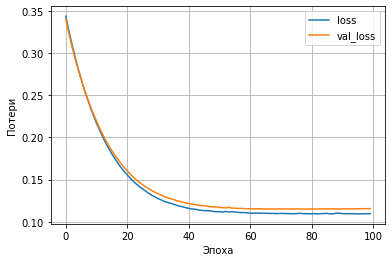

In [67]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.grid(True)

In [68]:
model_1.save('my_model_1.h5')

In [69]:
model_1 = load_model('my_model_1.h5')

In [70]:
type(x_test_1)

pandas.core.frame.DataFrame

In [71]:
predict_1 = model.predict(x_test_1)
#print(x_test_1[:selection].values)




10/10 [==============================] - 0s 2ms/step


In [72]:
i = 0
for item in y_test_1:
    print(item, '  /  ', predict_1[i][0])
    i+=1

0.5567236312540272   /   0.5082087
0.45282307879842326   /   0.46823058
0.5180400909229632   /   0.49851242
0.7016505995284126   /   0.47139472
0.3609108296362568   /   0.500553
0.47385775445814227   /   0.50388855
0.5979302604702869   /   0.5018245
0.45200421326581663   /   0.50056076
0.20038755984626375   /   0.49731615
0.5487664496100795   /   0.49713302
0.5209272782229496   /   0.45733145
0.7786199558719411   /   0.5050695
0.4285914662707241   /   0.5058293
0.3777466681339908   /   0.50801927
0.41279097571088763   /   0.4747053
0.3703435936035055   /   0.5089075
0.6376724942089287   /   0.5115173
0.3281062860415018   /   0.5013509
0.43749690441339084   /   0.48456457
0.5007000920499113   /   0.47209808
0.5683158950250733   /   0.49831545
0.6724841614993798   /   0.51147985
0.7971293244324347   /   0.5072726
0.6015662364139269   /   0.4824605
0.4751515023361304   /   0.4734096
0.4580470108376417   /   0.51297355
0.68589036717814   /   0.49453396
0.5358580217652517   /   0.4717604
0.

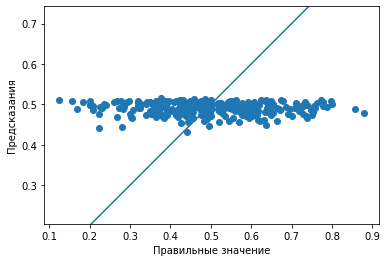

In [73]:
plt.scatter(y_test_1, predict_1) 
plt.xlabel('Правильные значение')
plt.ylabel('Предсказания')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.plot([-100, 100], [-100, 100])
plt.show()

In [74]:
mae_1 = mean_absolute_error(predict_1, y_test_1)
mse_1 = mean_squared_error(predict_1, y_test_1)
score_1 = r2_score(predict_1, y_test_1)
print('mae_1: ', mae_1)
print('mse_1: ', mse_1)
print('score_1: ', score_1)

mae_1:  0.11508586519816441
mse_1:  0.020750164690561342
score_1:  -90.57538055326691


### Модель 2

In [75]:
input = Input(shape=(input_shape,))

branch_outputs = []
for i in range(input_shape):
#    out = Lambda(lambda x: x[:, i])(input)

    # Setting up your per-channel layers (replace with actual sub-models):
    out = Dense(16)(input)
    branch_outputs.append(out)

# Concatenating together the per-channel results:
out_1 = Concatenate()(branch_outputs)

# Adding some further layers (replace or remove with your architecture):
out_2 = Dense(64)(out_1)
out_3 = Dense(1)(out_2)

# Building model:
model_2 = Model(inputs=input, outputs=out_3)    
model_2.compile(loss="mse", optimizer="adam")
model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 dense_20 (Dense)               (None, 16)           208         ['input_4[0][0]']                
                                                                                                  
 dense_21 (Dense)               (None, 16)           208         ['input_4[0][0]']                
                                                                                                  
 dense_22 (Dense)               (None, 16)           208         ['input_4[0][0]']                
                                                                                            

In [76]:
history_2=model_2.fit(x_train_1, y_train_1, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
18/18 [==============================] - 2s 20ms/step - loss: 0.1603 - val_loss: 0.0942
Epoch 2/10
18/18 [==============================] - 0s 4ms/step - loss: 0.0476 - val_loss: 0.0407
Epoch 3/10
18/18 [==============================] - 0s 4ms/step - loss: 0.0231 - val_loss: 0.0273
Epoch 4/10
18/18 [==============================] - 0s 4ms/step - loss: 0.0212 - val_loss: 0.0242
Epoch 5/10
18/18 [==============================] - 0s 4ms/step - loss: 0.0215 - val_loss: 0.0244
Epoch 6/10
18/18 [==============================] - 0s 4ms/step - loss: 0.0224 - val_loss: 0.0273
Epoch 7/10
18/18 [==============================] - 0s 4ms/step - loss: 0.0212 - val_loss: 0.0241
Epoch 8/10
18/18 [==============================] - 0s 4ms/step - loss: 0.0238 - val_loss: 0.0271
Epoch 9/10
18/18 [==============================] - 0s 4ms/step - loss: 0.0238 - val_loss: 0.0228
Epoch 10/10
18/18 [==============================] - 0s 4ms/step - loss: 0.0205 - val_loss: 0.0228


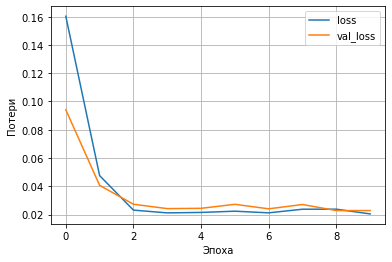

In [77]:
plt.plot(history_2.history['loss'], label='loss')
plt.plot(history_2.history['val_loss'], label='val_loss')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.grid(True)

In [78]:
model_2.save('my_model_2.h5')

In [79]:
model_2 = load_model('my_model_2.h5')

In [80]:
predict_2 = model_2.predict(x_test_1)

10/10 [==============================] - 0s 2ms/step


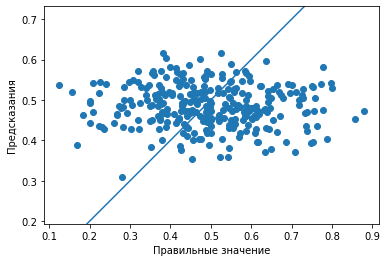

In [81]:
plt.scatter(y_test_1, predict_2) 
plt.xlabel('Правильные значение')
plt.ylabel('Предсказания')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.plot([-100, 100], [-100, 100])
plt.show()

In [82]:
mae_2 = mean_absolute_error(predict_2, y_test_1)
mse_2 = mean_squared_error(predict_2, y_test_1)
score_2 = r2_score(predict_2, y_test_1)
print('mae_2: ', mae_2)
print('mse_2: ', mse_2)
print('score_2: ', score_2)

mae_2:  0.12470499881315851
mse_2:  0.02381214884596513
score_2:  -7.521801451984588


## Лассо регрессия

In [83]:
# class sklearn.linear_model.Lasso(alpha=1.0, *, fit_intercept=True, normalize='deprecated', precompute=False, 
#    copy_X=True, max_iter=1000, tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')

clf = Lasso(alpha=0.001,
           max_iter = 1000000,
           random_state = 42,
           selection = 'cyclic')
clf.fit(x_train_1, y_train_1)
y_pred_clf = clf.predict(x_test_1)
mae_clf = mean_absolute_error(y_pred_clf, y_test_1)
mse_clf_elast = mean_squared_error(y_test_1,y_pred_clf)
print('Lasso regressor Results Train:')
print("Test score: {:.2f}".format(clf.score(x_train_1, y_train_1)))# Скор для тренировочной выборки
print('Lasso regressor Results:')
print('SGD_MAE: ', round(mean_absolute_error(y_test_1, y_pred_clf)))
print('SGD_MAPE: {:.2f}'.format(mean_absolute_percentage_error(y_test_1, y_pred_clf)))
print('SGD_MSE: {:.2f}'.format(mse_clf_elast))
print("SGD_RMSE: {:.2f}".format (np.sqrt(mse_clf_elast)))
print("Test score: {:.2f}".format(clf.score(x_test_1, y_test_1)))# Скор для тестовой выборки

Lasso regressor Results Train:
Test score: 0.01
Lasso regressor Results:
SGD_MAE:  0
SGD_MAPE: 0.28
SGD_MSE: 0.02
SGD_RMSE: 0.14
Test score: -0.01


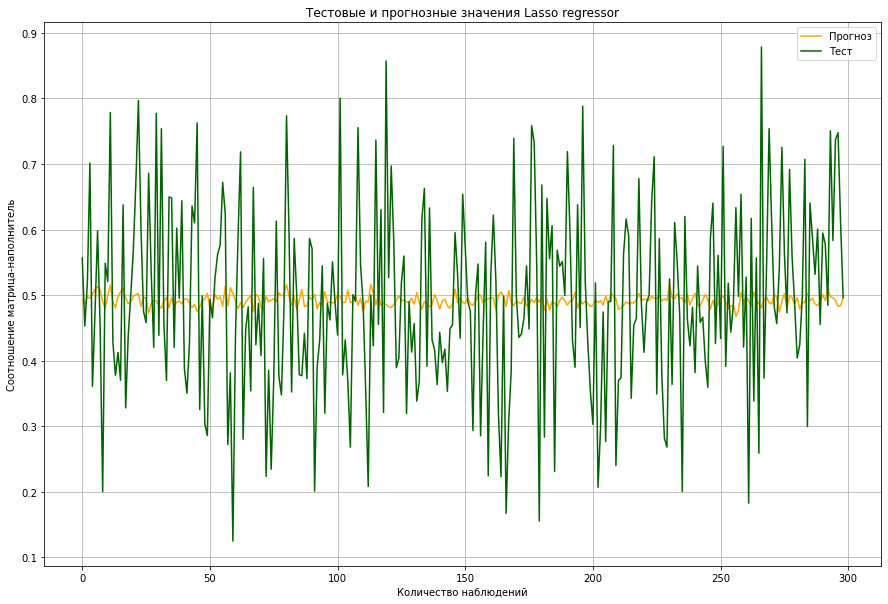

In [84]:
plt.figure(figsize = (15, 10))
plt.title("Тестовые и прогнозные значения Lasso regressor")
plt.plot(y_pred_clf, label = "Прогноз", color = 'orange')
plt.plot(y_test_1, label = "Тест", color = 'darkgreen')
plt.xlabel("Количество наблюдений")
plt.ylabel(target_val)
plt.legend()
plt.grid(True);

## 7. Оценка точности моделей для рекомендации состава